# <span style="color:blue;">**Brain Tumor Classification Project**</span>

### **Dataset:**

https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data

* 3264 MRI jpeg scans. One scan per patients.

* Three different tumors =  four different labels.

    - "pituitary_tumor" : class 3
    - "meningioma_tumor" : class 2
    - "glioma_tumor" : class 1
    - "No tumor" : class 0

* Two sets: Train and Test

    - Train:
        - "pituitary_tumor" : 827 files
        - "meningioma_tumor" : 822 files
        - "glioma_tumor" : 826 files
        - "No tumor" : 395 files (unbalanced class)
    
    - Test:
        - "pituitary_tumor" : 74 files (quite unbalanced class)
        - "meningioma_tumor" : 115 files
        - "glioma_tumor" : 100 files
        - "No tumor" : 105 files     

### **Table of Contents**

0. **Visualization**

1. **Classification**
    - 1.a. Model Definition
    - 1.b. Dataset preparation
    - 1.c. Model Training, Learning curves
    - 1.d. Metrics
    - 1.e. Results

2. **Calibration of the model**
    - 2.a. ECE Metric
    - 2.b. Temperature Scaling
    - 2.c. Monte Carlo Dropout
    - 2.d. Calibration results
    - 2.e. Uncertainty per class

3. **XAI**
    - 3.a. GradCam implementation
    - 3.b. Results



In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### **0. Visualization**

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

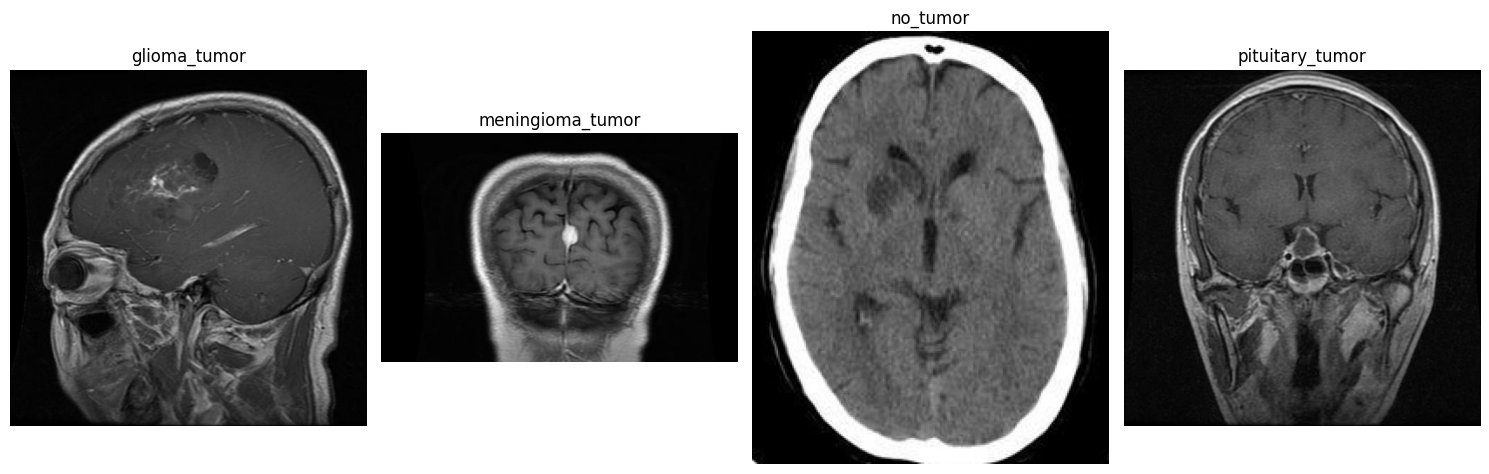

In [ ]:
# Define dataset path
dataset_path = "/content/drive/My Drive/dataset_brain_tumor_classif/Training"

# Define the four tumor classes
classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Display four example images (one per class)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i, tumor_class in enumerate(classes):
    class_path = os.path.join(dataset_path, tumor_class)
    image_name = os.listdir(class_path)[0]  # Get the first image
    image_path = os.path.join(class_path, image_name)

    # Read and convert image to RGB
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot image
    axes[i].imshow(image)
    axes[i].set_title(tumor_class)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### **1. Classification**

#### **1.a Models definition**

In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torchvision.models as models

class ResNet(nn.Module):
    def __init__(self, num_class:int, model_name:str, trainable_layers = None, wgth = None):
        super().__init__()
        available_models = {
            'ResNet50' : models.resnet50,
            'ResNet34' : models.resnet34,
            'ResNet18' : models.resnet18,
            'ResNet101' : models.resnet101
        }
        if model_name not in available_models.keys():
            raise ValueError(f' ** ERROR ** Chose model name between : {available_models.keys()}')
        else :
            self.model = available_models[model_name](weights="IMAGENET1K_V1")

        # modifying fc layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_class)

        # freeze -- unfreeze trainable layers
        for name, param in self.model.named_parameters():
            if any(layer in name for layer in trainable_layers):
                param.requires_grad = True
            else :
                param.requires_grad = False

        if wgth :
            self.model.load_state_dict(torch.load(wgth))

            print(f' ** Weights loadded from {wgth} **')


    def forward(self,x):
        return self.model(x)


#### **1.b. Dataset preparation**

##### Split into Train / Val / Test

The dataset used for this section was scomposed of 2 main folder one for the trainning images and the other one for the testing images. Since we wanted to have validation data to guide us in selecting a good model, we created this function that take p% of the content of the initial folder(train images) and move it to another folder (validation images).

In [ ]:
import pandas as pd
import os
import random
import shutil



def move_random_files(src_root: str, root_new_folder: str, p=0.1) -> None:
    """
    Move p % files randomly selected
    :param src_root:
    :param root_new_folder:
    :param p:
    :return:
    """

    if not os.path.exists(root_new_folder):
        os.makedirs(root_new_folder)

    list_im = [f for f in os.listdir(src_root) if os.path.isfile(os.path.join(src_root, f))]
    num2move = int(len(list_im) * p)
    im2move = random.sample(list_im, num2move)

    for im_path in im2move:
        src_path = str(src_root + '/' + im_path)
        dest_path = str(root_new_folder + '/' + im_path)
        shutil.move(src_path, dest_path)
    print('** done **')



# create folder validation with 10% of the initial training set
move_random_files(src_root='/content/drive/My Drive/dataset_brain_tumor_classif/train/glioma_tumor',
                  root_new_folder='/content/drive/My Drive/dataset_brain_tumor_classif/val/glioma_tumor')

move_random_files(
    src_root='/content/drive/My Drive/dataset_brain_tumor_classif/train/meningioma_tumor',
    root_new_folder='/content/drive/My Drive/dataset_brain_tumor_classif/val/meningioma_tumor')

move_random_files(
    src_root='/content/drive/My Drive/dataset_brain_tumor_classif/train/no_tumor',
    root_new_folder='/content/drive/My Drive/dataset_brain_tumor_classif/val/no_tumor')

move_random_files(
    src_root='/content/drive/My Drive/dataset_brain_tumor_classif/train/pituitary_tumor',
    root_new_folder='/content/drive/My Drive/dataset_brain_tumor_classif/val/pituitary_tumor')

** done **
** done **
** done **
** done **


##### Dataset Class creation

This Dataset is structured in the following way :
|- train
  |- class1
  |- class2
  ...
|- validation
  |- class1
  ...

Thanks to that we where able to directly use torch datasets.ImageFolder that deal with dataset of this kind.

In [ ]:
import os
import pandas as pd
from torchvision import transforms, datasets
from collections import Counter
from torch.utils.data.dataset import Dataset



class Dataset2D(Dataset):
    def __init__(self, data_root:str, mode:str,transforms = None):
        super().__init__()
        self.transform = transforms
        if mode not in ['train', 'val', 'test']:
            raise ValueError('Chose mode between : "train" or "test" ')
        self.mode = mode
        self.dataset = datasets.ImageFolder(str(data_root + '/' + mode), transform = self.transform)
        self.class_id = self.dataset.class_to_idx

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx] # -> img, label

    def get_info(self)->None:
        """ Display dataset information """
        class_count = Counter(self.dataset.targets)
        print(f' Classes identification : {self.class_id}', '\n',
              f' Classes distribution - {self.mode} : ','\n')

        total_len = len(self.dataset)
        for class_idx, count in class_count.items():
            print(f'class : {self.dataset.classes[class_idx]} - : {count/total_len *100:.2f}%')


##### Data augmentation

In [ ]:
import torch
from patsy.test_highlevel import test_env_transform
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim



data_root = 'content/drive/MyDrive/dataset_brain_tumor_classif' ## PATH TO DATASET ##


train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    # data augmentation
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=(-0.2, +0.2)),

    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


##### Train_loader + Val_loader + Test_loader

In [ ]:
data_root = '/content/drive/MyDrive/dataset_brain_tumor_classif'

train_dataset = Dataset2D(data_root=data_root,
                          transforms=train_transforms,
                          mode='train')

val_dataset = Dataset2D(data_root=data_root,
                        transforms=train_transforms,
                        mode='val')

test_dataset = Dataset2D(data_root=data_root,
                          transforms=test_transforms,
                          mode='test')
# display data info
train_dataset.get_info()
test_dataset.get_info()

# store class identification
classes_dico = test_dataset.dataset.class_to_idx
classes_names = list(classes_dico.keys())

# Dataloadders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


 Classes identification : {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3} 
  Classes distribution - train :  

class : glioma_tumor - : 28.78%
class : meningioma_tumor - : 28.61%
class : no_tumor - : 13.79%
class : pituitary_tumor - : 28.82%
 Classes identification : {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3} 
  Classes distribution - test :  

class : glioma_tumor - : 25.38%
class : meningioma_tumor - : 29.19%
class : no_tumor - : 26.65%
class : pituitary_tumor - : 18.78%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#### **1.c. Model Training, Learning curves**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

def train(model, train_loader, val_loader, num_epochs=25, lr=1e-4, device=None, tolerance=5, delta_tol=0.02, name_wtg=''):
    """
    Train the given model using CrossEntropyLoss and Adam optimizer.

    Parameters:
    - model (nn.Module): The neural network model to train.
    - train_loader (DataLoader): The training data loader.
    - val_loader (DataLoader): The validation data loader.
    - num_epochs (int): Number of training epochs (default: 25).
    - lr (float): Learning rate (default: 1e-4).
    - device (str or torch.device): Computing device (default: auto-detect GPU if available).
    - tolerance (int): Number of epochs to wait before early stopping (default: 5).
    - delta_tol (float): Minimum change in validation loss to reset tolerance counter (default: 0.02).
    - name_wtg (str): Name tag for saving the best model.

    Returns:
    - None (saves the best model and plots the learning curve).
    """

    # Define save path in Google Drive
    save_path = "/content/drive/MyDrive/models_classif"
    os.makedirs(save_path, exist_ok=True)  # Ensure directory exists

    # Automatically detect GPU if available
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("Using device:", device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    train_losses = []
    val_losses = []
    tolerance_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()
        train_loss = 0.0
        loop = tqdm(train_loader, leave=True, desc=f"Training Epoch {epoch + 1}")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())  # Show loss evolution in tqdm progress bar

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Save best model (lowest validation loss)
        if val_loss == min(val_losses):
            best_model = model.state_dict()
            best_model_path = os.path.join(save_path, f"best_model_{name_wtg}_epoch{epoch+1}.pth")
            torch.save(best_model, best_model_path)

        # Early stopping mechanism
        if (epoch > 2) and (val_loss >= val_losses[-2] - delta_tol):
            tolerance_counter += 1
            if tolerance_counter == tolerance:
                print(f"** EARLY STOPPING ** at epoch: {epoch + 1}")
                early_stop_path = os.path.join(save_path, f"best_model_{name_wtg}_epoch{epoch+1}_early_stop.pth")
                torch.save(model.state_dict(), early_stop_path)
                break
        else:
            tolerance_counter = 0  # Reset tolerance counter if loss improves

    # Save final best model
    final_model_path = os.path.join(save_path, f"best_model_{name_wtg}_epoch{epoch+1}.pth")
    torch.save(best_model, final_model_path)

    # Plot Learning Curves
    plt.figure(figsize=(8, 6))
    print(f"** Total epochs: {epoch+1} | Train loss entries: {len(train_losses)} **")
    plt.plot(range(1, epoch+2), train_losses, label="Train Loss", marker="o")
    plt.plot(range(1, epoch+2), val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Learning Curves")
    plt.grid()
    plt.show()


Using device: cuda

Epoch 1/35


Training Epoch 1: 100%|██████████| 37/37 [00:06<00:00,  5.70it/s, loss=0.117]


Train Loss: 0.4792 | Val Loss: 0.5689

Epoch 2/35


Training Epoch 2: 100%|██████████| 37/37 [00:06<00:00,  5.57it/s, loss=0.218]


Train Loss: 0.1306 | Val Loss: 0.1492

Epoch 3/35


Training Epoch 3: 100%|██████████| 37/37 [00:06<00:00,  5.51it/s, loss=0.0314]


Train Loss: 0.0651 | Val Loss: 0.1524

Epoch 4/35


Training Epoch 4: 100%|██████████| 37/37 [00:06<00:00,  5.88it/s, loss=0.113]


Train Loss: 0.0419 | Val Loss: 0.1193

Epoch 5/35


Training Epoch 5: 100%|██████████| 37/37 [00:06<00:00,  5.67it/s, loss=0.00731]


Train Loss: 0.0316 | Val Loss: 0.1220

Epoch 6/35


Training Epoch 6: 100%|██████████| 37/37 [00:06<00:00,  5.75it/s, loss=0.011]


Train Loss: 0.0179 | Val Loss: 0.0894

Epoch 7/35


Training Epoch 7: 100%|██████████| 37/37 [00:06<00:00,  5.75it/s, loss=0.00559]


Train Loss: 0.0116 | Val Loss: 0.0944

Epoch 8/35


Training Epoch 8: 100%|██████████| 37/37 [00:06<00:00,  5.77it/s, loss=0.00158]


Train Loss: 0.0077 | Val Loss: 0.0839

Epoch 9/35


Training Epoch 9: 100%|██████████| 37/37 [00:06<00:00,  5.85it/s, loss=0.00738]


Train Loss: 0.0103 | Val Loss: 0.1354

Epoch 10/35


Training Epoch 10: 100%|██████████| 37/37 [00:06<00:00,  5.73it/s, loss=0.00645]


Train Loss: 0.0074 | Val Loss: 0.0987

Epoch 11/35


Training Epoch 11: 100%|██████████| 37/37 [00:06<00:00,  5.83it/s, loss=0.00257]


Train Loss: 0.0058 | Val Loss: 0.1063

Epoch 12/35


Training Epoch 12: 100%|██████████| 37/37 [00:06<00:00,  5.92it/s, loss=0.000937]


Train Loss: 0.0037 | Val Loss: 0.1009

Epoch 13/35


Training Epoch 13: 100%|██████████| 37/37 [00:06<00:00,  5.74it/s, loss=0.0281]


Train Loss: 0.0050 | Val Loss: 0.1042

Epoch 14/35


Training Epoch 14: 100%|██████████| 37/37 [00:06<00:00,  5.93it/s, loss=0.00495]


Train Loss: 0.0034 | Val Loss: 0.0969

Epoch 15/35


Training Epoch 15: 100%|██████████| 37/37 [00:06<00:00,  5.93it/s, loss=0.00253]


Train Loss: 0.0029 | Val Loss: 0.0879
** EARLY STOPPING ** at epoch: 15
** Total epochs: 15 | Train loss entries: 15 **


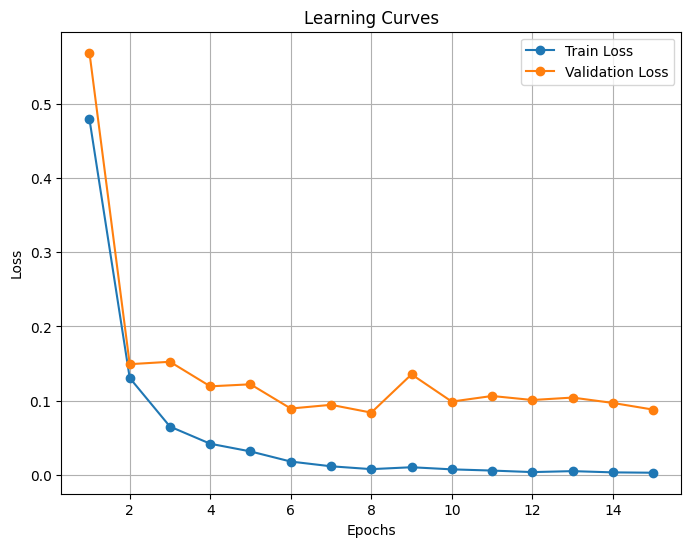

Using device: cuda

Epoch 1/35


Training Epoch 1: 100%|██████████| 37/37 [00:06<00:00,  5.78it/s, loss=1.31]


Train Loss: 1.3256 | Val Loss: 1.1991

Epoch 2/35


Training Epoch 2: 100%|██████████| 37/37 [00:06<00:00,  5.65it/s, loss=1.18]


Train Loss: 1.2237 | Val Loss: 1.0605

Epoch 3/35


Training Epoch 3: 100%|██████████| 37/37 [00:06<00:00,  5.64it/s, loss=1.04]


Train Loss: 1.1354 | Val Loss: 0.9537

Epoch 4/35


Training Epoch 4: 100%|██████████| 37/37 [00:06<00:00,  5.54it/s, loss=1.03]


Train Loss: 1.0579 | Val Loss: 0.9189

Epoch 5/35


Training Epoch 5: 100%|██████████| 37/37 [00:06<00:00,  5.33it/s, loss=1.02]


Train Loss: 0.9952 | Val Loss: 0.8457

Epoch 6/35


Training Epoch 6: 100%|██████████| 37/37 [00:06<00:00,  5.70it/s, loss=0.978]


Train Loss: 0.9442 | Val Loss: 0.7939

Epoch 7/35


Training Epoch 7: 100%|██████████| 37/37 [00:06<00:00,  5.60it/s, loss=0.794]


Train Loss: 0.8937 | Val Loss: 0.7495

Epoch 8/35


Training Epoch 8: 100%|██████████| 37/37 [00:06<00:00,  5.69it/s, loss=1.01]


Train Loss: 0.8588 | Val Loss: 0.7155

Epoch 9/35


Training Epoch 9: 100%|██████████| 37/37 [00:06<00:00,  5.56it/s, loss=0.725]


Train Loss: 0.8184 | Val Loss: 0.6908

Epoch 10/35


Training Epoch 10: 100%|██████████| 37/37 [00:06<00:00,  5.62it/s, loss=0.898]


Train Loss: 0.7901 | Val Loss: 0.6517

Epoch 11/35


Training Epoch 11: 100%|██████████| 37/37 [00:06<00:00,  5.76it/s, loss=0.607]


Train Loss: 0.7565 | Val Loss: 0.6277

Epoch 12/35


Training Epoch 12: 100%|██████████| 37/37 [00:07<00:00,  5.21it/s, loss=0.656]


Train Loss: 0.7295 | Val Loss: 0.6054

Epoch 13/35


Training Epoch 13: 100%|██████████| 37/37 [00:07<00:00,  5.27it/s, loss=0.856]


Train Loss: 0.7235 | Val Loss: 0.5958

Epoch 14/35


Training Epoch 14: 100%|██████████| 37/37 [00:06<00:00,  5.52it/s, loss=0.732]


Train Loss: 0.6975 | Val Loss: 0.5527

Epoch 15/35


Training Epoch 15: 100%|██████████| 37/37 [00:06<00:00,  5.63it/s, loss=0.715]


Train Loss: 0.6740 | Val Loss: 0.5603

Epoch 16/35


Training Epoch 16: 100%|██████████| 37/37 [00:06<00:00,  5.73it/s, loss=0.568]


Train Loss: 0.6531 | Val Loss: 0.5210

Epoch 17/35


Training Epoch 17: 100%|██████████| 37/37 [00:06<00:00,  5.53it/s, loss=0.608]


Train Loss: 0.6397 | Val Loss: 0.5300

Epoch 18/35


Training Epoch 18: 100%|██████████| 37/37 [00:06<00:00,  5.68it/s, loss=0.65]


Train Loss: 0.6327 | Val Loss: 0.5357

Epoch 19/35


Training Epoch 19: 100%|██████████| 37/37 [00:06<00:00,  5.96it/s, loss=0.554]


Train Loss: 0.6156 | Val Loss: 0.5145

Epoch 20/35


Training Epoch 20: 100%|██████████| 37/37 [00:06<00:00,  5.34it/s, loss=0.602]


Train Loss: 0.6048 | Val Loss: 0.4778

Epoch 21/35


Training Epoch 21: 100%|██████████| 37/37 [00:06<00:00,  5.71it/s, loss=0.653]


Train Loss: 0.5975 | Val Loss: 0.4900

Epoch 22/35


Training Epoch 22: 100%|██████████| 37/37 [00:06<00:00,  5.82it/s, loss=0.61]


Train Loss: 0.5808 | Val Loss: 0.4852

Epoch 23/35


Training Epoch 23: 100%|██████████| 37/37 [00:06<00:00,  5.70it/s, loss=0.457]


Train Loss: 0.5718 | Val Loss: 0.4795

Epoch 24/35


Training Epoch 24: 100%|██████████| 37/37 [00:06<00:00,  6.06it/s, loss=0.431]


Train Loss: 0.5640 | Val Loss: 0.4629

Epoch 25/35


Training Epoch 25: 100%|██████████| 37/37 [00:06<00:00,  5.63it/s, loss=0.682]


Train Loss: 0.5649 | Val Loss: 0.4629
** EARLY STOPPING ** at epoch: 25
** Total epochs: 25 | Train loss entries: 25 **


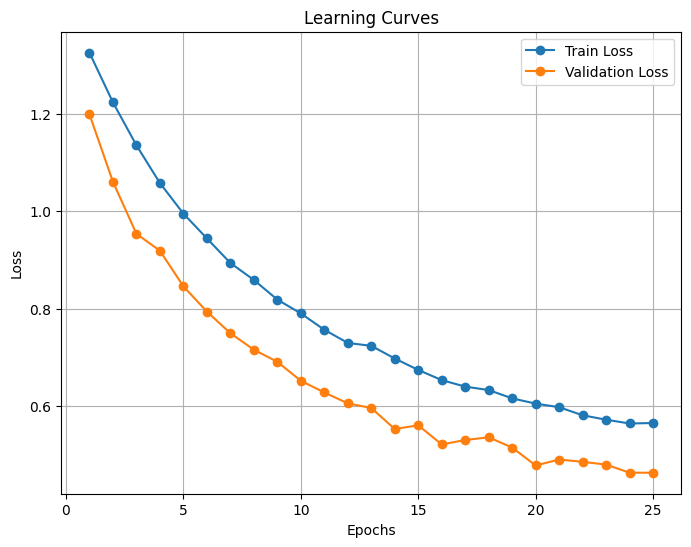

Using device: cuda

Epoch 1/35


Training Epoch 1: 100%|██████████| 37/37 [00:06<00:00,  5.54it/s, loss=0.216]


Train Loss: 0.4938 | Val Loss: 0.2710

Epoch 2/35


Training Epoch 2: 100%|██████████| 37/37 [00:06<00:00,  5.64it/s, loss=0.0802]


Train Loss: 0.1256 | Val Loss: 0.1786

Epoch 3/35


Training Epoch 3: 100%|██████████| 37/37 [00:06<00:00,  5.40it/s, loss=0.00685]


Train Loss: 0.0529 | Val Loss: 0.1243

Epoch 4/35


Training Epoch 4: 100%|██████████| 37/37 [00:06<00:00,  5.37it/s, loss=0.00613]


Train Loss: 0.0175 | Val Loss: 0.1153

Epoch 5/35


Training Epoch 5: 100%|██████████| 37/37 [00:07<00:00,  5.16it/s, loss=0.00387]


Train Loss: 0.0127 | Val Loss: 0.0959

Epoch 6/35


Training Epoch 6: 100%|██████████| 37/37 [00:06<00:00,  5.54it/s, loss=0.111]


Train Loss: 0.0136 | Val Loss: 0.1592

Epoch 7/35


Training Epoch 7: 100%|██████████| 37/37 [00:06<00:00,  5.66it/s, loss=0.00863]


Train Loss: 0.0254 | Val Loss: 0.1592

Epoch 8/35


Training Epoch 8: 100%|██████████| 37/37 [00:06<00:00,  5.74it/s, loss=0.0121]


Train Loss: 0.0179 | Val Loss: 0.0744

Epoch 9/35


Training Epoch 9: 100%|██████████| 37/37 [00:06<00:00,  5.46it/s, loss=0.0126]


Train Loss: 0.0122 | Val Loss: 0.1000

Epoch 10/35


Training Epoch 10: 100%|██████████| 37/37 [00:06<00:00,  5.78it/s, loss=0.00479]


Train Loss: 0.0063 | Val Loss: 0.0671

Epoch 11/35


Training Epoch 11: 100%|██████████| 37/37 [00:06<00:00,  5.77it/s, loss=0.0682]


Train Loss: 0.0121 | Val Loss: 0.1073

Epoch 12/35


Training Epoch 12: 100%|██████████| 37/37 [00:06<00:00,  5.62it/s, loss=0.0939]


Train Loss: 0.0103 | Val Loss: 0.1367

Epoch 13/35


Training Epoch 13: 100%|██████████| 37/37 [00:06<00:00,  5.95it/s, loss=0.0307]


Train Loss: 0.0122 | Val Loss: 0.1423

Epoch 14/35


Training Epoch 14: 100%|██████████| 37/37 [00:06<00:00,  5.79it/s, loss=0.0224]


Train Loss: 0.0085 | Val Loss: 0.1805

Epoch 15/35


Training Epoch 15: 100%|██████████| 37/37 [00:06<00:00,  5.63it/s, loss=0.000967]


Train Loss: 0.0153 | Val Loss: 0.1928
** EARLY STOPPING ** at epoch: 15
** Total epochs: 15 | Train loss entries: 15 **


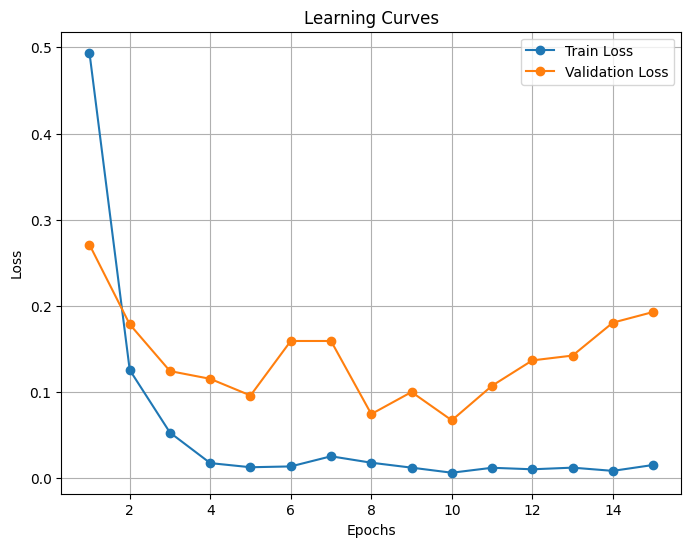

Using device: cuda

Epoch 1/35


Training Epoch 1: 100%|██████████| 37/37 [00:06<00:00,  6.00it/s, loss=0.285]


Train Loss: 0.5107 | Val Loss: 0.3938

Epoch 2/35


Training Epoch 2: 100%|██████████| 37/37 [00:06<00:00,  5.61it/s, loss=0.51]


Train Loss: 0.1699 | Val Loss: 0.1687

Epoch 3/35


Training Epoch 3: 100%|██████████| 37/37 [00:06<00:00,  5.95it/s, loss=0.044]


Train Loss: 0.0801 | Val Loss: 0.1331

Epoch 4/35


Training Epoch 4: 100%|██████████| 37/37 [00:06<00:00,  5.67it/s, loss=0.0607]


Train Loss: 0.0430 | Val Loss: 0.1347

Epoch 5/35


Training Epoch 5: 100%|██████████| 37/37 [00:06<00:00,  5.52it/s, loss=0.0137]


Train Loss: 0.0237 | Val Loss: 0.1064

Epoch 6/35


Training Epoch 6: 100%|██████████| 37/37 [00:06<00:00,  5.87it/s, loss=0.00798]


Train Loss: 0.0121 | Val Loss: 0.1106

Epoch 7/35


Training Epoch 7: 100%|██████████| 37/37 [00:06<00:00,  5.81it/s, loss=0.025]


Train Loss: 0.0091 | Val Loss: 0.1141

Epoch 8/35


Training Epoch 8: 100%|██████████| 37/37 [00:06<00:00,  5.84it/s, loss=0.0977]


Train Loss: 0.0102 | Val Loss: 0.1143

Epoch 9/35


Training Epoch 9: 100%|██████████| 37/37 [00:06<00:00,  5.95it/s, loss=0.0282]


Train Loss: 0.0073 | Val Loss: 0.1066

Epoch 10/35


Training Epoch 10: 100%|██████████| 37/37 [00:06<00:00,  5.79it/s, loss=0.00404]


Train Loss: 0.0047 | Val Loss: 0.0948
** EARLY STOPPING ** at epoch: 10
** Total epochs: 10 | Train loss entries: 10 **


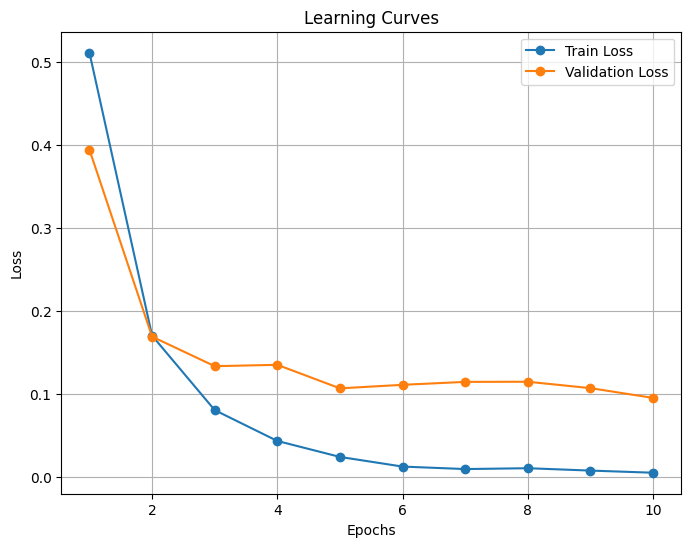

In [ ]:

# models
resnet50 = ResNet(num_class=4, model_name='ResNet50', trainable_layers=['layer4', 'fc'])
resnet34 = ResNet(num_class=4, model_name='ResNet34', trainable_layers=['layer4', 'fc'])
resnet34_l = ResNet(num_class=4, model_name='ResNet34', trainable_layers=['fc'])
resnet18 = ResNet(num_class=4, model_name='ResNet18', trainable_layers=['layer4', 'fc'])



# train
train(resnet34, train_loader, val_loader, num_epochs = 35, name_wtg='resnet34')
train(resnet34_l, train_loader, val_loader, num_epochs=35, name_wtg='resnet34_l', delta_tol=0.02)
train(resnet50, train_loader, val_loader, num_epochs=35, name_wtg='resnet50')
train(resnet18, train_loader, val_loader, num_epochs=35, name_wtg='resnet18')

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

Looking to the learning curves, we can see the stability of the learning process and check the values of the trainning and validation losses.
To prevent overfitting, we have set an early stopping criteria to stop the learning if the validation loss doesn't improuve consequently during 5 epochs.

We have tried different resnet configuration varying the number of layers of the neural network. For most configuration, we have finetuned the last layer and the forth convolution layer. We also have trainned a resnet34 finetunning only the fully connected layer and we can see that it was not enogth to ensure good results on both trainning and validation set.

Looking to the differents results, we can clearly say that the REsNet34 configuration performed the best with a stable leanring as shown in the learning curve.

We can perhaps note that we had little data to ensure the validation test.

</div>

#### **1.d. Metrics & Evaluation**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader

def evaluation(model, loader, classes_names: list):
    """
    Evaluation of the model
    :param model: model with loaded weights
    :param test_loader: test data loader
    :param classes_names:(list) list of class names
    :return: None, plot confusion matrix & display classification report
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Ensure the model is on the same device as the input images
    model.to(device)
    model.eval()

    preds = []
    labels = []

    with torch.no_grad():
        for im, label in loader:
            im, label = im.to(device), label.to(device)  # Move images & labels to correct device
            out = model(im)
            pred = torch.argmax(out, dim=1)  # Get predicted labels

            preds.extend(pred.cpu().numpy())  # Convert to numpy (move to CPU first)
            labels.extend(label.cpu().numpy())  # Move labels to CPU before appending

    # Print Classification Report
    print(classification_report(labels, preds, target_names=classes_names))
    print('\n')
    # Compute & Display Confusion Matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes_names, yticklabels=classes_names, cmap="Blues")
    plt.xticks(rotation=45, ha='right')  # ha='right' ensures better alignment
    plt.yticks(rotation=0)  # Keep y-axis labels horizontal
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


#### **1.e. Classification results**

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 216MB/s]
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 207MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 225MB/s]
<ipython-input-7-1c7b25546090>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will b

                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.97      0.97        74
meningioma_tumor       0.95      0.93      0.94        74
        no_tumor       0.94      0.97      0.96        35
 pituitary_tumor       0.99      0.99      0.99        74

        accuracy                           0.96       257
       macro avg       0.96      0.97      0.96       257
    weighted avg       0.96      0.96      0.96       257





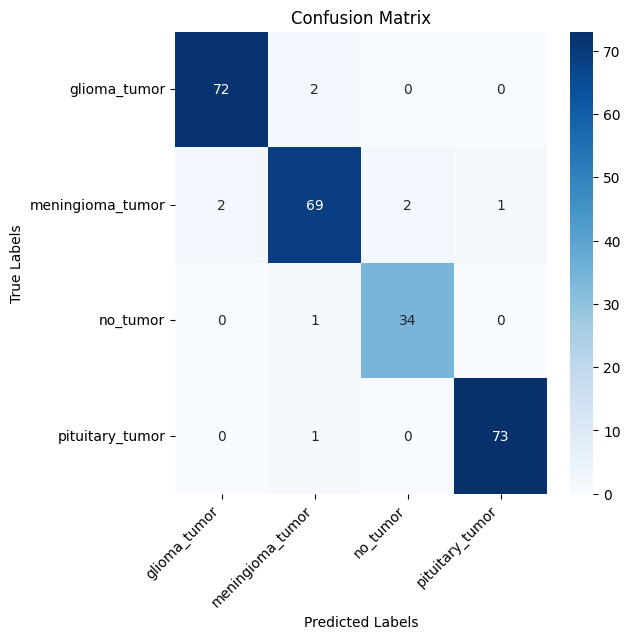







                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.97      0.96        74
meningioma_tumor       0.96      0.89      0.92        74
        no_tumor       0.94      0.97      0.96        35
 pituitary_tumor       0.97      1.00      0.99        74

        accuracy                           0.96       257
       macro avg       0.96      0.96      0.96       257
    weighted avg       0.96      0.96      0.96       257





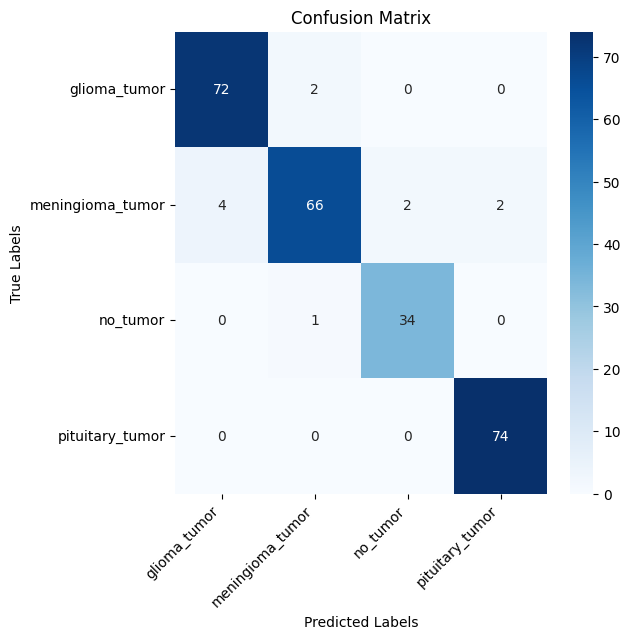







                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.81      0.85        74
meningioma_tumor       0.75      0.84      0.79        74
        no_tumor       0.92      0.66      0.77        35
 pituitary_tumor       0.87      0.96      0.91        74

        accuracy                           0.84       257
       macro avg       0.86      0.82      0.83       257
    weighted avg       0.85      0.84      0.84       257





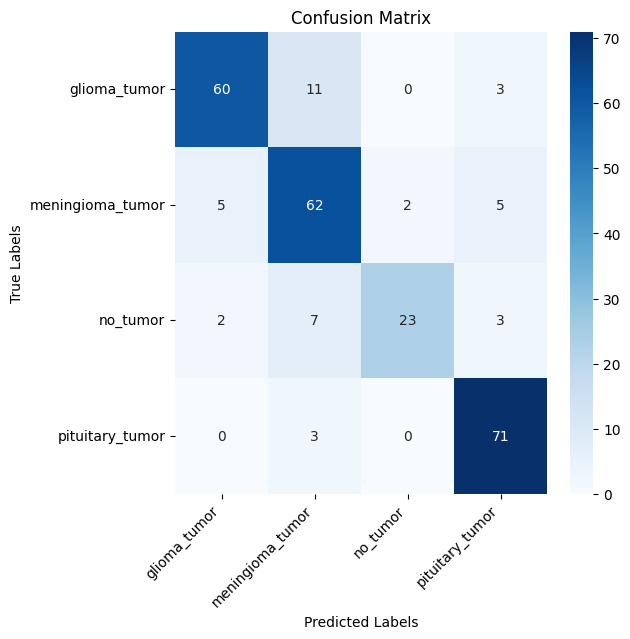







                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.93      0.96        74
meningioma_tumor       0.95      0.95      0.95        74
        no_tumor       0.95      1.00      0.97        35
 pituitary_tumor       0.97      1.00      0.99        74

        accuracy                           0.96       257
       macro avg       0.96      0.97      0.97       257
    weighted avg       0.97      0.96      0.96       257





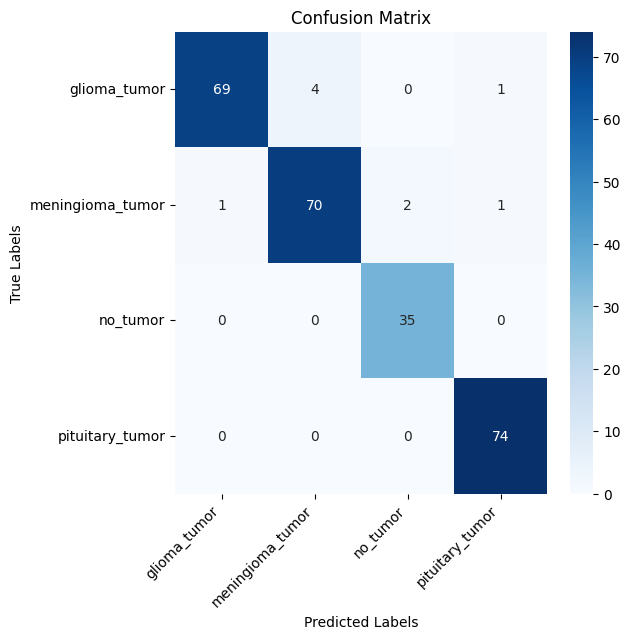

In [ ]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
resnet50 = ResNet(num_class=4, model_name='ResNet50', trainable_layers=['layer4', 'fc']).to(device)
resnet34 = ResNet(num_class=4, model_name='ResNet34', trainable_layers=['layer4', 'fc']).to(device)
resnet34_l = ResNet(num_class=4, model_name='ResNet34', trainable_layers=['fc']).to(device)
resnet18 = ResNet(num_class=4, model_name='ResNet18', trainable_layers=['layer4', 'fc']).to(device)

# Load weights (ensure consistency)
resnet18.load_state_dict(torch.load('/content/drive/MyDrive/models_classif/best_model_resnet18_epoch10.pth', map_location=device))
resnet34.load_state_dict(torch.load('/content/drive/MyDrive/models_classif/best_model_resnet34_epoch10.pth', map_location=device))
resnet34_l.load_state_dict(torch.load('/content/drive/MyDrive/models_classif/best_model_resnet34_l_epoch25.pth', map_location=device))
resnet50.load_state_dict(torch.load('/content/drive/MyDrive/models_classif/best_model_resnet50_epoch10.pth', map_location=device))

# List of models
our_models = [resnet18, resnet34, resnet34_l, resnet50]

# Define class labels
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Run evaluation for all models
for model in our_models:
    evaluation(model, val_loader, classes_names=labels)
    print('\n')
    print('\n')
    print('\n')

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

We have here differents metrics that help us understanding better the model performances.
We can note that we have some data presenting tumor miss classified as health patient it primarly occure with patient presenting glioma tumor. This class seems to be the most difficult to predict for the model.
We can also see that some classes of the tumor tend to be more confused than others and that the glioma tumor tend is the class  but we can be realy satistied over the general look of the confusion matrix !






</div>

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.21      0.35       100
meningioma_tumor       0.67      0.97      0.79       115
        no_tumor       0.73      1.00      0.85       105
 pituitary_tumor       0.98      0.85      0.91        74

        accuracy                           0.76       394
       macro avg       0.85      0.76      0.72       394
    weighted avg       0.83      0.76      0.72       394





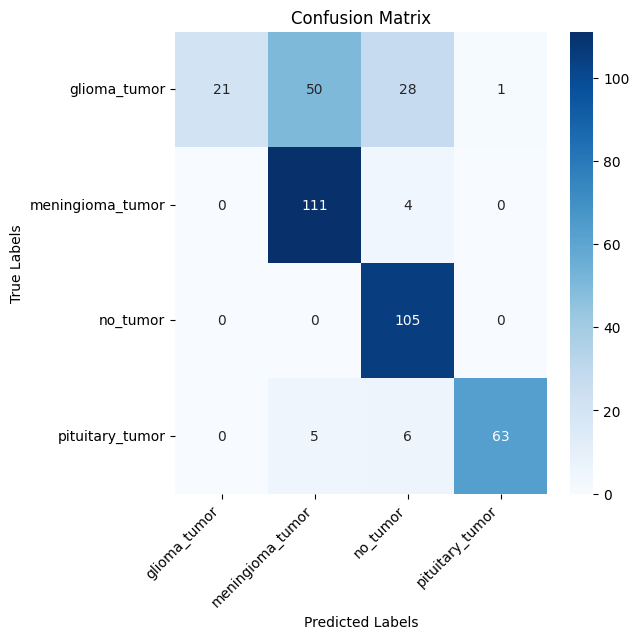

In [ ]:
best_model = resnet34
evaluation(best_model, test_loader, classes_names=labels)

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

When you look at the recall, precision and F1-score on the val dataset; Resnet34 and Resnet 50 are equivalent. However, as the learning curve of the Resnet34 is more stable. We have chosen this model as the "best model". Above are the final results on the test dataset.

The results are globally satisfying. But some classifications are dangerous: the misclassification of glioma_tumor (28 elements), meningioma_tumor(4 elements), pituitary_tumor(6 elements) as "no_tumor".

In a clinical application context, we absolutly don't want that one of the tumor is predicted as "no tumor".

### **2. Calibration of the model**

#### **2.a. ECE Metric**

In [ ]:
import torch
import numpy as np

def expected_calibration_error_classification(probs, labels, n_bins=10):
    """
    Computes the Expected Calibration Error (ECE) for a classification model.

    Args:
    - `probs`: tensor of shape `(num_samples, num_classes)`, containing predicted softmax probabilities.
    - `labels`: tensor of shape `(num_samples,)`, containing true class indices.
    - `n_bins` (int): Number of bins for calibration.

    Returns:
    - `float`: Expected Calibration Error (ECE)
    """
    bins = torch.linspace(0, 1, n_bins + 1, device=probs.device)  # Define bin edges
    bin_lowers, bin_uppers = bins[:-1], bins[1:]

    ece = 0.0

    # Compute predicted labels and confidence scores
    confidences, predicted_labels = probs.max(dim=1)  # (num_samples,)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Find samples whose confidence falls within this bin
        in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
        prop_in_bin = in_bin.float().mean()

        if prop_in_bin > 0:  # Avoid division by zero
            accuracy_in_bin = (predicted_labels[in_bin] == labels[in_bin]).float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()

            # Weighted sum of calibration error
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return ece.item()


#### **2.b. Temperature Scaling**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class TemperatureScaler(nn.Module):
    """
    Temperature Scaling module to calibrate a classification model.
    """
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)  # Initialize T > 1

    def forward(self, logits):
        return logits / self.temperature  # Scale the logits

def optimize_temperature(model, val_loader, device):
    """
    Optimize the temperature parameter T on the validation set.

    Args:
    - model (torch.nn.Module): The trained classification model.
    - val_loader (DataLoader): Validation set to optimize T.
    - device (torch.device): CUDA or CPU.

    Returns:
    - TemperatureScaler: A trained temperature scaling module.
    """
    model.to(device)
    model.eval()

    temperature_scaler = TemperatureScaler().to(device)
    optimizer = optim.LBFGS([temperature_scaler.temperature], lr=0.01, max_iter=50)

    criterion = nn.CrossEntropyLoss()

    # Collect logits and labels
    logits_list, labels_list = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)  # Get logits
            logits_list.append(logits)
            labels_list.append(labels)

    logits = torch.cat(logits_list, dim=0)  # (num_samples, num_classes)
    labels = torch.cat(labels_list, dim=0)  # (num_samples,)

    def eval():
        optimizer.zero_grad()
        loss = criterion(temperature_scaler(logits), labels)
        loss.backward()
        return loss

    optimizer.step(eval)

    print(f"Optimized Temperature: {temperature_scaler.temperature.item():.4f}")
    return temperature_scaler

def apply_temperature_scaling(model, test_loader, temperature_scaler, device):
    """
    Apply temperature scaling to the model outputs on the test set.

    Args:
    - model (torch.nn.Module): The trained classification model.
    - test_loader (DataLoader): Test set for evaluation.
    - temperature_scaler (TemperatureScaler): The trained calibration module.
    - device (torch.device): CUDA or CPU.

    Returns:
    - torch.Tensor: Softmax-calibrated probabilities (num_samples, num_classes).
    - torch.Tensor: True labels (num_samples,).
    """
    model.to(device)
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            calibrated_logits = temperature_scaler(logits)
            probs = torch.nn.functional.softmax(calibrated_logits, dim=1)

            all_probs.append(probs.cpu())  # Store on CPU to avoid issues
            all_labels.append(labels.cpu())

    return torch.cat(all_probs, dim=0), torch.cat(all_labels, dim=0)


#### **2.c. MonteCarlo Dropout**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetWithDropout(nn.Module):
    def __init__(self, num_class: int, model_name: str, trainable_layers=None, wgth=None, dropout_p=0.5):
        """
        ResNet model with Dropout added before the fully connected layer.

        Args:
        - num_class (int): Number of output classes.
        - model_name (str): The ResNet model to use ('ResNet18', 'ResNet34', 'ResNet50', 'ResNet101').
        - trainable_layers (list, optional): List of layers to unfreeze for training.
        - wgth (str, optional): Path to the model weights.
        - dropout_p (float, optional): Dropout probability (default: 0.5).
        """
        super().__init__()

        available_models = {
            'ResNet50': models.resnet50,
            'ResNet34': models.resnet34,
            'ResNet18': models.resnet18,
            'ResNet101': models.resnet101
        }

        if model_name not in available_models:
            raise ValueError(f'** ERROR ** Choose model name from: {list(available_models.keys())}')

        self.model = available_models[model_name](weights="IMAGENET1K_V1")

        # Modify the fully connected layer with Dropout
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(p=dropout_p),  # Added Dropout before classification layer
            nn.Linear(in_features, num_class)
        )

        # Freeze/unfreeze specific layers
        for name, param in self.model.named_parameters():
            if trainable_layers and any(layer in name for layer in trainable_layers):
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Load weights if provided
        if wgth:
            self.load_state_dict(torch.load(wgth))
            print(f'** Weights loaded from {wgth} **')

    def forward(self, x):
        return self.model(x)


In [ ]:
def enable_dropout(model):
    """
    Enables Dropout layers during inference.
    """
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()  # Keep Dropout active during inference


In [ ]:
import torch.nn.functional as F

def monte_carlo_dropout(model, test_loader, num_samples=30, device=None):
    """
    Performs Monte Carlo Dropout for model calibration.

    Args:
    - model (torch.nn.Module): The trained classification model.
    - test_loader (DataLoader): Test set for evaluation.
    - num_samples (int): Number of stochastic forward passes.
    - device (torch.device, optional): CUDA or CPU.

    Returns:
    - torch.Tensor: Mean probabilities (num_samples, num_classes).
    - torch.Tensor: Uncertainty (variance of probabilities, not logits).
    - torch.Tensor: True labels (num_samples,).
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()
    enable_dropout(model)  # Force Dropout to remain active

    all_probs = []
    all_labels = []
    all_uncertainty = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Perform multiple forward passes
            preds_softmax = torch.stack(
                [F.softmax(model(images), dim=1) for _ in range(num_samples)], dim=0
            )  # Shape: (num_samples, batch_size, num_classes)

            # Compute mean and variance of probabilities
            mean_probs = preds_softmax.mean(dim=0)  # (batch_size, num_classes)
            uncertainty = preds_softmax.var(dim=0)  # Variance of probabilities (not logits)

            all_probs.append(mean_probs.cpu())
            all_uncertainty.append(uncertainty.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(all_probs, dim=0), torch.cat(all_uncertainty, dim=0), torch.cat(all_labels, dim=0)


#### **2.d. Calibration results**

In [ ]:
import torch
import torch.nn.functional as F


def evaluate_model_ece(model, test_loader, device, n_bins=10):
    """
    Evaluates the Expected Calibration Error (ECE) of a classification model.

    Args:
    - model (torch.nn.Module): The trained classification model.
    - test_loader (DataLoader): Test dataset loader.
    - device (torch.device): Device (CPU/GPU).
    - n_bins (int): Number of bins for ECE computation.

    Returns:
    - float: ECE score.
    """
    model.to(device)
    model.eval()

    all_probs, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Get model outputs (logits) and apply softmax
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)

            # Store the results on CPU
            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all predictions and labels into single tensors
    all_probs = torch.cat(all_probs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Compute ECE
    return expected_calibration_error_classification(all_probs, all_labels, n_bins=n_bins)


def evaluate_with_temperature_scaling(model, val_loader, test_loader, device, n_bins=10):
    """
    Applies Temperature Scaling calibration and evaluates ECE.

    Args:
    - model (torch.nn.Module): The trained classification model.
    - val_loader (DataLoader): Validation dataset loader (for temperature optimization).
    - test_loader (DataLoader): Test dataset loader.
    - device (torch.device): Device (CPU/GPU).
    - n_bins (int): Number of bins for ECE computation.

    Returns:
    - float: ECE after Temperature Scaling.
    """
    # Optimize temperature using the validation set
    temperature_scaler = optimize_temperature(model, val_loader, device)

    # Apply temperature scaling on the test set
    calibrated_probs, true_labels = apply_temperature_scaling(
        model, test_loader, temperature_scaler, device
    )

    # Compute ECE after calibration
    return expected_calibration_error_classification(calibrated_probs, true_labels, n_bins=n_bins)


def evaluate_with_monte_carlo_dropout(model_path, test_loader, device, num_samples=100, n_bins=10):
    """
    Applies Monte Carlo Dropout calibration and evaluates ECE.

    Args:
    - model_path (str): Path to the trained model weights.
    - test_loader (DataLoader): Test dataset loader.
    - device (torch.device): Device (CPU/GPU).
    - num_samples (int): Number of Monte Carlo forward passes.
    - n_bins (int): Number of bins for ECE computation.

    Returns:
    - float: ECE after Monte Carlo Dropout.
    """
    # Load ResNet model with Dropout
    model = ResNetWithDropout(
        num_class=4, model_name="ResNet50", trainable_layers=["layer4", "fc"]
    )

    # Load weights without strict matching
    model.load_state_dict(torch.load(model_path), strict=False)

    model.to(device)

    # Enable Dropout for Monte Carlo inference
    enable_dropout(model)

    # Perform Monte Carlo Dropout on test set
    mc_probs, _, true_labels = monte_carlo_dropout(
        model, test_loader, num_samples=num_samples, device=device
    )

    # Compute ECE after Monte Carlo Dropout
    return expected_calibration_error_classification(mc_probs, true_labels, n_bins=n_bins)





In [ ]:
import torch

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model **without Dropout** (to match training)
model_path = "/content/drive/MyDrive/models_classif/best_model_resnet50_epoch10.pth"
best_model = ResNet(num_class=4, model_name="ResNet50", trainable_layers=["layer4", "fc"])

# Load weights correctly
best_model.load_state_dict(torch.load(model_path))

# Move model to device
best_model.to(device)

# Enable Dropout at inference for MC Dropout
enable_dropout(best_model)


# Compute ECE before calibration
ece_before = evaluate_model_ece(best_model, test_loader, device)
print(f"Expected Calibration Error (ECE) without calibration: {ece_before:.4f}")

# Compute ECE with Temperature Scaling
ece_temp_scaling = evaluate_with_temperature_scaling(best_model, val_loader, test_loader, device)
print(f"Expected Calibration Error (ECE) with Temperature Scaling: {ece_temp_scaling:.4f}")

# Compute ECE with Monte Carlo Dropout
ece_mc_dropout = evaluate_with_monte_carlo_dropout(model_path, test_loader, device, num_samples=100)
print(f"Expected Calibration Error (ECE) with Monte Carlo Dropout: {ece_mc_dropout:.4f}")

<ipython-input-71-6a02725c4655>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path))


Expected Calibration Error (ECE) without calibration: 0.1725
Optimized Temperature: 1.4600
Expected Calibration Error (ECE) with Temperature Scaling: 0.1442


<ipython-input-67-7187b6ce7674>:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path), strict=False)


Expected Calibration Error (ECE) with Monte Carlo Dropout: 0.0435


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

1. Optimized Temperature: 1.4600

Our model was globally overconfident.

2. ECE(without calibration) = 0.1725 --> ECE(Temp Scaling) = 0.1442

The Temperature Scaling calibration method proves beneficial with a slight decrease in ECE.

3. ECE(without calibration) = 0.1725 --> ECE(MC Dropout) = 0.0435

The Monte Carlo Dropout calibration method is very effective, leading to a significant drop in ECE.


</div>

#### **2.e. Uncertainty per class with MonteCarlo Dropout**

In [ ]:
import pandas as pd
import torch

def compute_classwise_uncertainty(mc_uncertainty, true_labels, class_names=None):
    """
    Computes the average uncertainty (variance and standard deviation) per true class.

    Args:
    - mc_uncertainty (torch.Tensor): Shape (N, num_classes), representing
      the variance per sample for each class (computed on probabilities).
    - true_labels (torch.Tensor): Shape (N,), the ground truth class for each sample.
    - class_names (list, optional): List of class names for display.

    Returns:
    - pd.DataFrame: DataFrame with columns ['Class', 'Mean_Variance', 'Std_Deviation'].
    """
    if class_names is None:
        num_classes = mc_uncertainty.size(1)
        class_names = [f"Class_{i}" for i in range(num_classes)]

    data = []
    for c, class_name in enumerate(class_names):
        idx = (true_labels == c)

        if idx.sum() > 0:
            # Extract variance for class c among those samples
            class_variance = mc_uncertainty[idx, c]
            mean_variance = class_variance.mean().item()
            std_deviation = class_variance.sqrt().mean().item()  # Compute standard deviation
        else:
            mean_variance = float('nan')
            std_deviation = float('nan')

        data.append([class_name, mean_variance, std_deviation])

    df_uncertainty = pd.DataFrame(data, columns=["Class", "Mean_Variance", "Std_Deviation"])
    return df_uncertainty




In [ ]:
model_path = "/content/drive/MyDrive/models_classif/best_model_resnet50_epoch10.pth"

model = ResNetWithDropout(
    num_class=4, model_name="ResNet50", trainable_layers=["layer4", "fc"]
)

# Load weights without strict matching
model.load_state_dict(torch.load(model_path), strict=False)

model.to(device)

# Enable Dropout for Monte Carlo inference
enable_dropout(model)

# Perform Monte Carlo Dropout on test set
mc_probs, mc_uncertainty, true_labels = monte_carlo_dropout(model, test_loader, num_samples=100, device=device)

# Compute uncertainty per class
labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
df_uncertainty = compute_classwise_uncertainty(mc_uncertainty, true_labels, class_names=labels)
display(df_uncertainty)


<ipython-input-77-d2790a64dce5>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path), strict=False)


Class  Mean_Variance  Std_Deviation
0      glioma_tumor       0.006864       0.081407
1  meningioma_tumor       0.008399       0.089876
2          no_tumor       0.005059       0.070356
3   pituitary_tumor       0.003715       0.060289

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

1. High values

The global value of each mean of uncertainty is clearly too high to apply this model in a production context.

For instance, confidence(meningioma_tumor) = value ± 9% !

2. Ranking

Our model is more certain on glioma_tumors and no_tumor label.

This was predictable given the F1-score results for the different classes. The model is more uncertain where it performs the worst.


</div>

### **3. XAI**

#### **3.a GradCAM implementation**

In [ ]:
from PIL import Image
import numpy as np
import cv2
from IPython.display import Image

In [ ]:
resnet50 = ResNet(num_class=4, model_name='ResNet50', trainable_layers=['layer4', 'fc'])
resnet50.load_state_dict(torch.load('/content/drive/MyDrive/best_model_resnet50_epoch10.pth'))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]
<ipython-input-12-dc9a5492d721>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

<All keys matched successfully>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

ResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [ ]:
# target layer for Grad-Cam (last convulational layer )
target_layer = resnet50.model.layer4[-1]

# lists to save gradients and activations
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.clear()
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.clear()
    gradients.append(grad_output[0])

target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

def grad_cam(path_image, model,transform):
    model.eval()

    image = Image.open(path_image).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device) # preprocess

    # reset gradients and activations
    activations.clear()
    gradients.clear()

    # forward pass
    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()

    # backward pass
    model.zero_grad()
    output[:, pred_class].backward(retain_graph=True)

    # Grad-CAM heatmap
    weights = torch.mean(gradients[0], dim=[2, 3]).view(1, -1, 1, 1)

    heatmap = torch.sum(weights * activations[0], dim=1).squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap /= np.max(heatmap)  # normalization [0,1]

    img = img_tensor.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    img = (img * 255).astype(np.uint8)

    # resize heatmap to fit the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # convert in RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # put the heatmap on the original image
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # plot the result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Original MRI Scan")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Grad-CAM Visualization")
    plt.show()

    print(f"Predicted Class: {list(test_dataset.class_id.keys())[pred_class]}")

#### **3.b Results**

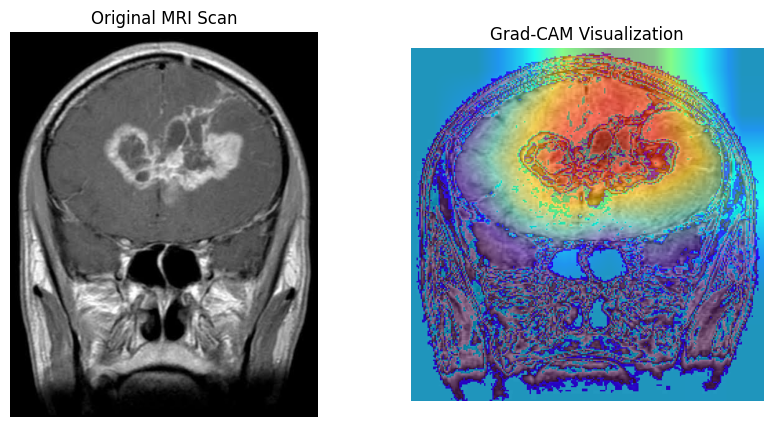

Predicted Class: glioma_tumor


In [ ]:
# Glioma tumor
test_image = "/content/drive/MyDrive/dataset_brain_tumor_classif/test/glioma_tumor/image(1).jpg"
grad_cam(test_image, resnet50, test_transforms)

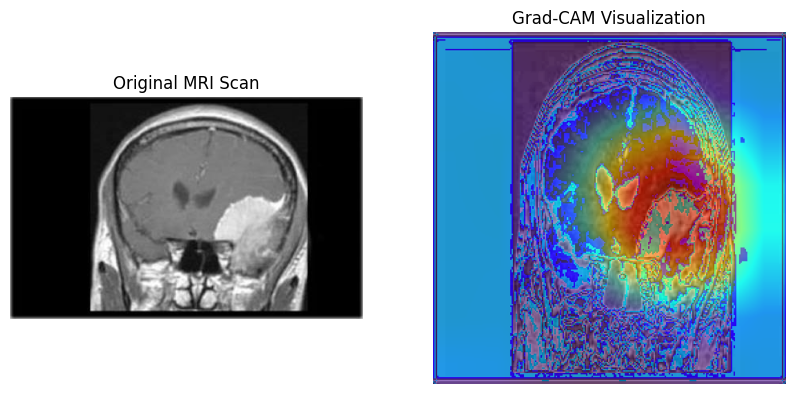

Predicted Class: meningioma_tumor


In [ ]:
# Meningioma tumor
test_image = "/content/drive/MyDrive/dataset_brain_tumor_classif/test/meningioma_tumor/image(1).jpg"
grad_cam(test_image, resnet50, test_transforms)

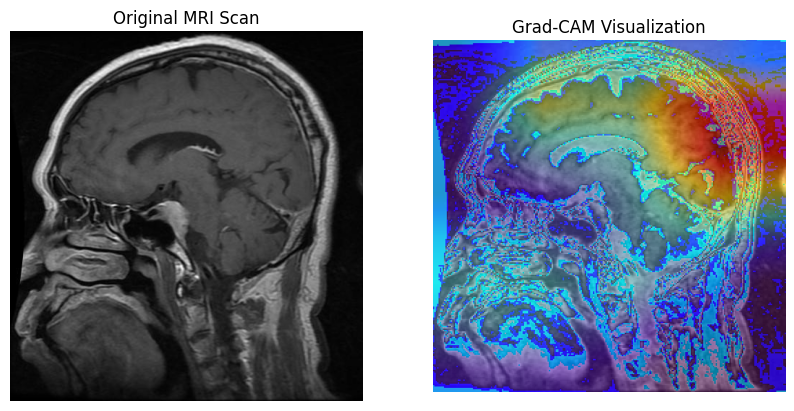

Predicted Class: pituitary_tumor


In [ ]:
# Pituitary tumor
test_image = "/content/drive/MyDrive/dataset_brain_tumor_classif/test/pituitary_tumor/image(3).jpg"
grad_cam(test_image, resnet50, test_transforms)

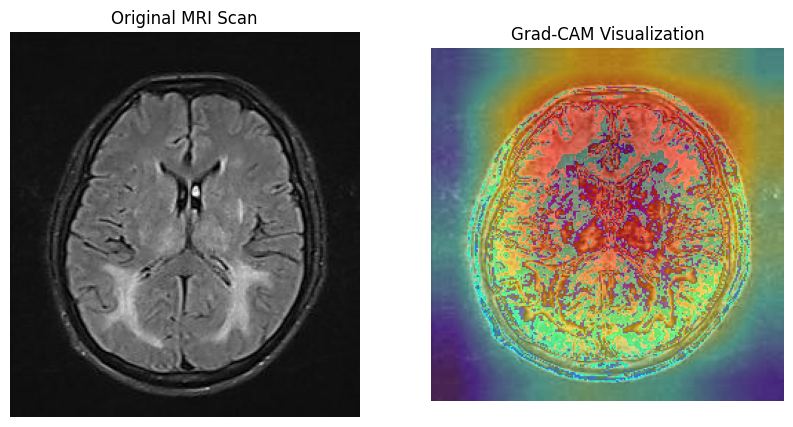

Predicted Class: no_tumor


In [ ]:
# No tumor
test_image = "/content/drive/MyDrive/dataset_brain_tumor_classif/test/no_tumor/image(10).jpg"
grad_cam(test_image,  resnet50, test_transforms)

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

Those results were obtained with a resnet50. We can see with the few examples above that it is good at classifying correctly the different tumors and at recognising when there is no tumor. The Grad-Cam method allows us to see which part of the image was used by the model to make a decision by using the target gradients of the last convulational layer.

</div>

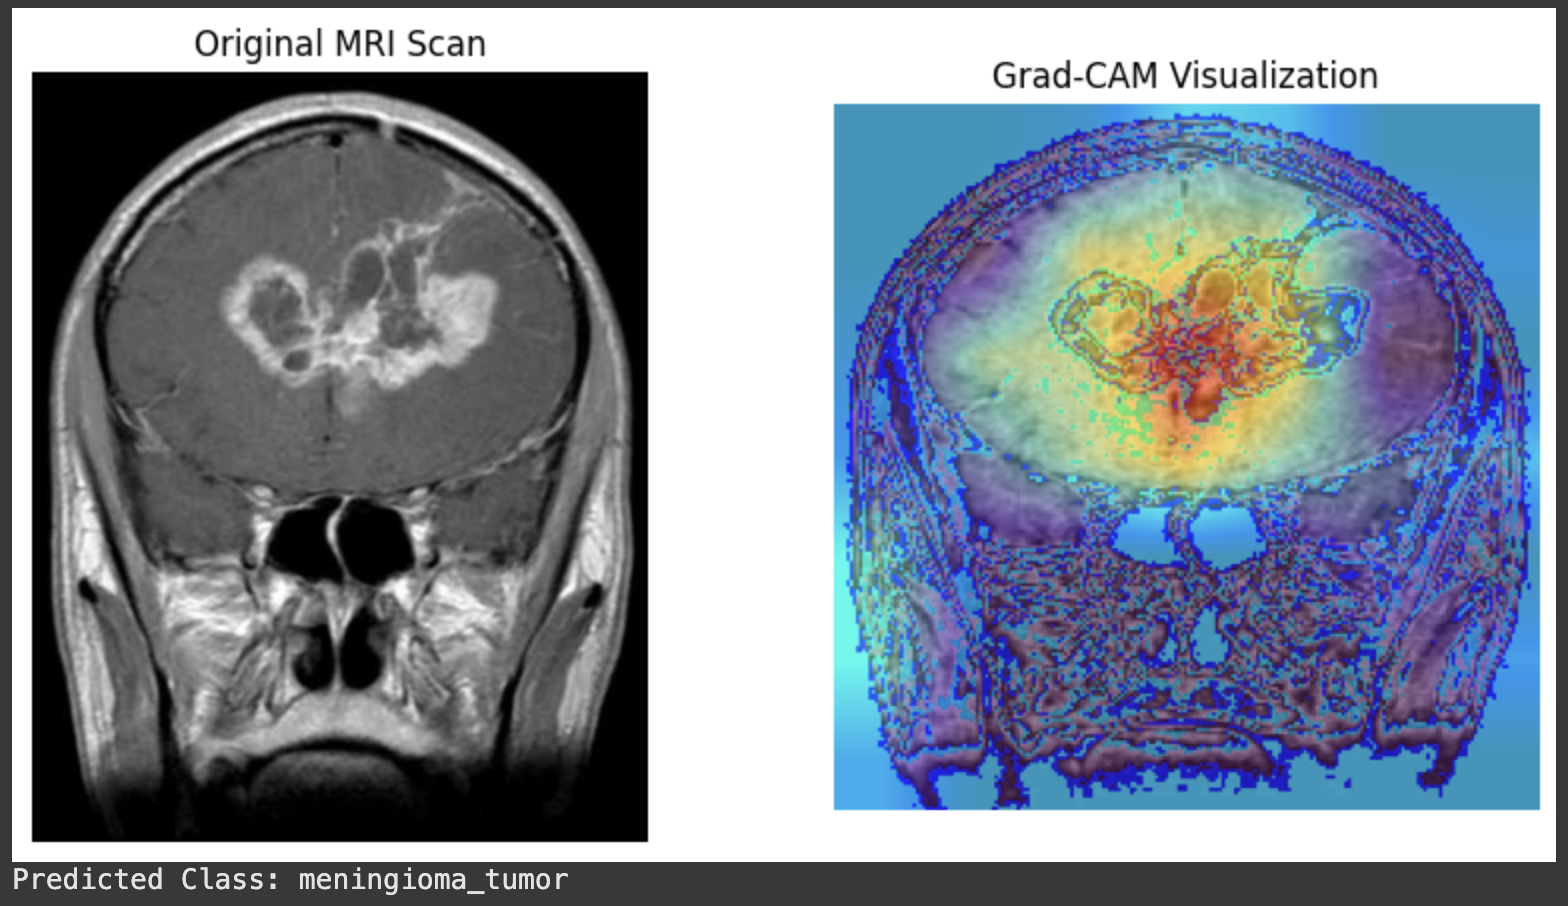

In [ ]:
Image("wrong_tumor.png",width=800)

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

**<font color='green'>Comment:</font>**  

During the testing phase of the project, we tried using a Resnet18, but the prediction weren't as good as with a Resnet50. However, it allowed us to have an example of the model :

1. correctly using the tumor to take its decision but not making the correct prediction. Here the model predicted a menongioma tumor instead of a glioma tumor (see image above).  

2. being able to correctly predict the tumor but by looking at the wrong part of the image which means that the tumor isn't the reason the model took it's decision (see image below).

</div>

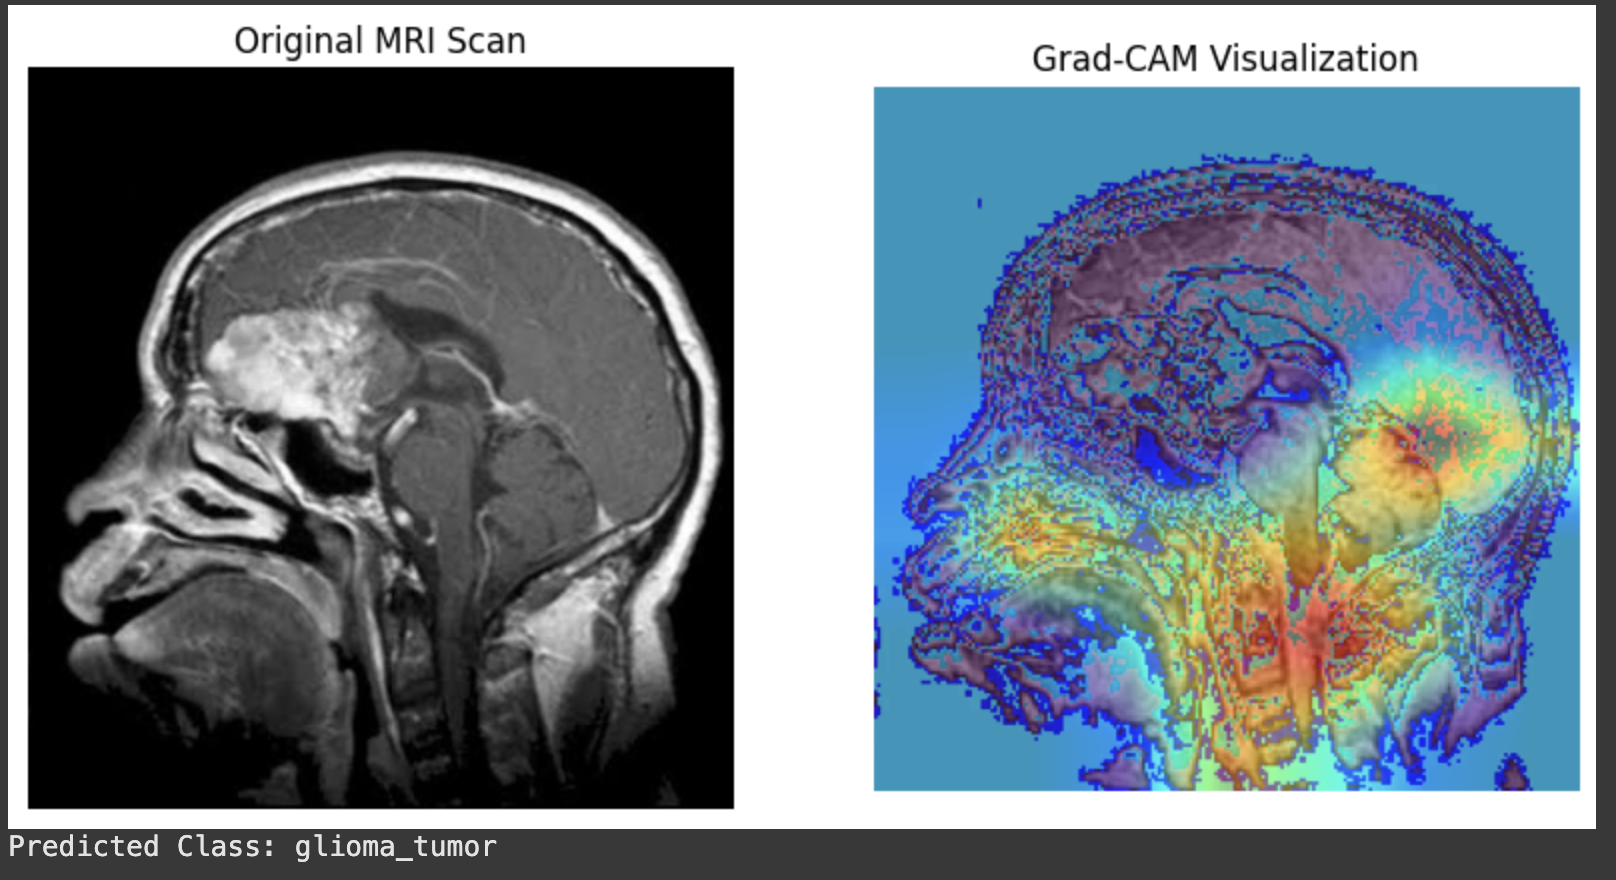

In [ ]:
Image("right_tumor.png",width=800)